In [1]:
from util import load_data
from correction import CorrectionByScaling, CorrectionByModel
from color_conversion import convert_rgb_cols, convert_to_rgb
from constants import ColorSpace
import pandas as pd
import matplotlib.pyplot as plt
from plot import *

df_daylight1 = load_data("Data/Jonas1.json")
df_daylight1["lighting_condition"] = "daylight"
df_daylight2 = load_data("Data/Baisu1.json")
df_daylight2["lighting_condition"] = "daylight"
# df_dark1 = load_data("Data/Tai4.json")
# df_dark1["lighting_condition"] = "dark"
# df_dark2 = load_data("Data/Zhi3.json")
# df_dark2["lighting_condition"] = "dark"

df_raw = pd.concat([df_daylight1, df_daylight2], ignore_index=True)
for prefix in ["color_r4_", "gt__"]:
    df_raw = convert_rgb_cols(df_raw, prefix, to=ColorSpace.HSV)
    df_raw = convert_rgb_cols(df_raw, prefix, to=ColorSpace.LAB)

df_train = df_raw.sample(frac=0.8, random_state=42)
training_indices = df_train.index
df_test = df_raw.drop(training_indices)

corrector_scaling = CorrectionByScaling(space=ColorSpace.RGB)
df_scaling = corrector_scaling.apply_correction(df_raw.copy())
df_test_scaling = corrector_scaling.apply_correction(df_test.copy())

corrector_model_rgb = CorrectionByModel(space=ColorSpace.RGB, boundary_penalty_factor=0.0)
corrector_model_rgb.train(df_train.copy())
df_test_model_rgb = corrector_model_rgb.apply_correction(df_test.copy())

corrector_model_lab = CorrectionByModel(space=ColorSpace.LAB, boundary_penalty_factor=0.0)
corrector_model_lab.train(df_train.copy())
df_test_model_lab = corrector_model_lab.apply_correction(df_test.copy())

train finished, coeffs shape: (6, 3)
coeffs: [[ 2.60757764  0.85711578  4.21160501]
 [-0.05516832 -0.24311217  1.36407896]
 [ 0.11018074  1.6239344   0.04026928]
 [ 1.28571816 -0.05420372 -0.02983371]
 [-0.33712951 -0.37960393 -0.56379363]]
coeffs: [[ 2.60757764  0.85711578  4.21160501]
 [-0.05516832 -0.24311217  1.36407896]
 [ 0.11018074  1.6239344   0.04026928]
 [ 1.28571816 -0.05420372 -0.02983371]
 [-0.33712951 -0.37960393 -0.56379363]
 [-0.12454483 -0.07476854 -0.13035361]]
train finished, coeffs shape: (6, 3)
coeffs: [[ 3.29331837  2.55390703 -0.8307352 ]
 [ 0.09757647 -0.20006556  1.40680126]
 [-0.10062546  1.31622139 -0.09009054]
 [ 1.25717355  0.01572942 -0.06813053]
 [-0.1304666   0.02882522  0.09759146]]
coeffs: [[ 3.29331837  2.55390703 -0.8307352 ]
 [ 0.09757647 -0.20006556  1.40680126]
 [-0.10062546  1.31622139 -0.09009054]
 [ 1.25717355  0.01572942 -0.06813053]
 [-0.1304666   0.02882522  0.09759146]
 [-0.03389478 -0.02106142  0.02222914]]


## Problem

- We want to know the color of an object.
- Naive approach: take a photo and use color picker.
- Ambient light affects the measured color.
- Goal: recover the true color by post-hoc correction.
- Initial idea:
    - Assume that the measured color $(R_0, G_0, B_0)$ of a white reference (e.g., white paper) is the "whitest" color we could measure given the lighting condition.
    - Scale the measurable color space $[0, R_0] \times [0, G_0] \times [0, B_0]$ back to $[0, 255] \times [0, 255] \times [0, 255]$.
- Does scaling suffice? Can we improve?

## Data

24 reference color cards with known ground-truth RGB values.
We take 10 photos of the color card along with a white sheet of paper (using our app) and measure

- the RGB values of the color card,
- the RGB values of a white sheet of paper,
- the pitch and roll of the phone when taking the photo.

Lighting conditions:

- Daylight through a window. ($\leftarrow$ focus)
- Dark room.
- Extreme red/blue/green light.

## Methods and Results

Color space matters:

- RGB: default storage format, "scaling" makes sense.
- HSV: separation of Hue and Saturation from Value (brightness)
- LAB: defined by the International Commission on Illumination, perceptually uniform

<img src="https://upload.wikimedia.org/wikipedia/commons/3/33/HSV_color_solid_cylinder_saturation_gray.png" width=400 />
<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/CIEHLC_polar.png" width=300 />

Visual checks:

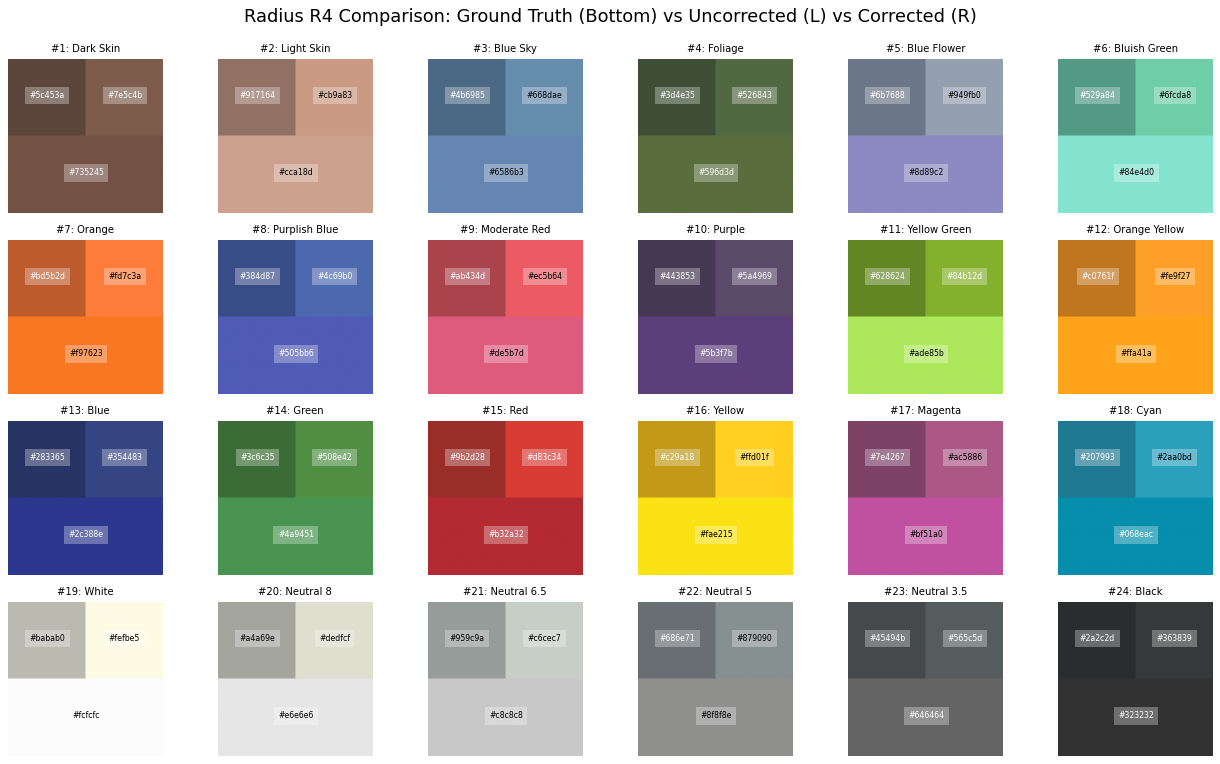

In [2]:
plot_comparison_grid(df_scaling);

Raw vs. corrected RGB values per color:

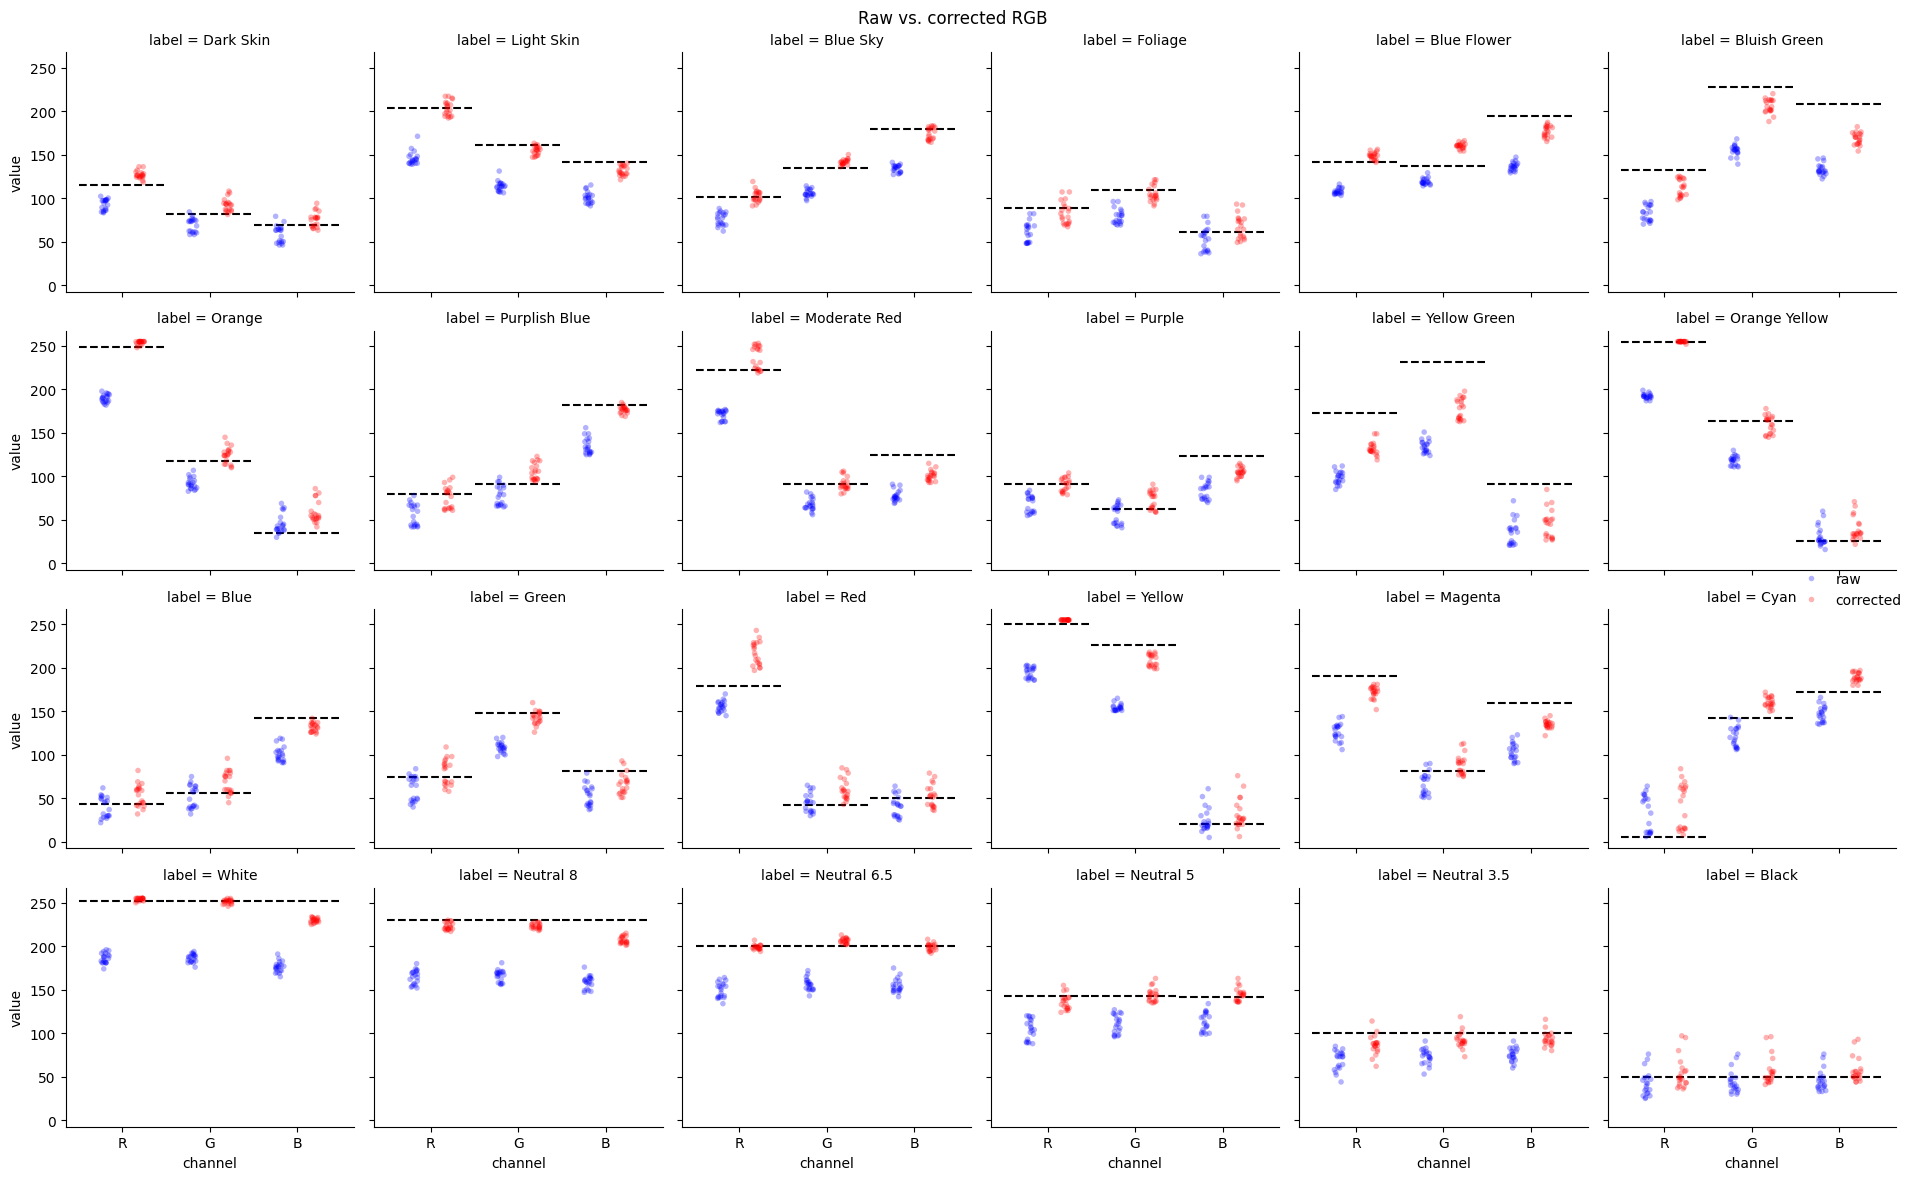

In [3]:
from plot import plot_against_gt
g = plot_against_gt(df_scaling, space=ColorSpace.RGB)
g.figure.suptitle("Raw vs. corrected RGB")
g.figure.tight_layout()
plt.show()

RGB values are difficult to interpret.

Scaling in RGB, evaluation in HSV:

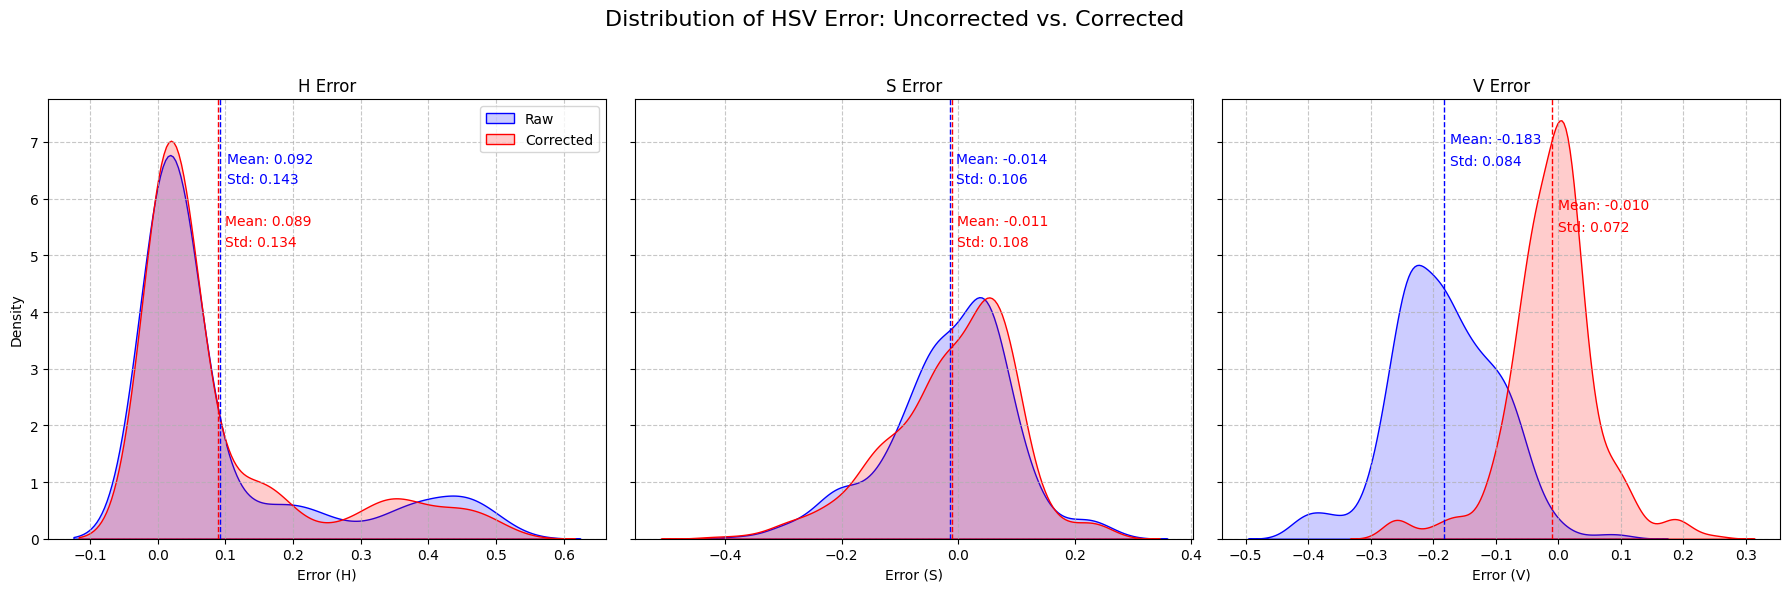

In [4]:
plotHSV(df_scaling);

Scaling helps with Value (brightness). Can we learn a better transformation for H and S?

Linear model:

$$
\begin{pmatrix}
    R_\textup{corr} \\ 
    G_\textup{corr} \\ 
    B_\textup{corr}
\end{pmatrix} = \begin{pmatrix}
    w_{11} & w_{12} & w_{13} \\
    w_{21} & w_{22} & w_{23} \\
    w_{31} & w_{32} & w_{33}
\end{pmatrix} \begin{pmatrix}
    R_\textup{meas} \\
    G_\textup{meas} \\
    B_\textup{meas}
\end{pmatrix} + \begin{pmatrix}
    b_1 \\
    b_2 \\
    b_3
\end{pmatrix} + \begin{pmatrix}
    c_{11} & c_{12} \\
    c_{21} & c_{22} \\
    c_{31} & c_{32}
\end{pmatrix} \begin{pmatrix}
    \textup{pitch} \\
    \textup{roll}
\end{pmatrix}
$$

80% -- 20% train-test split on measurements under daylight condition

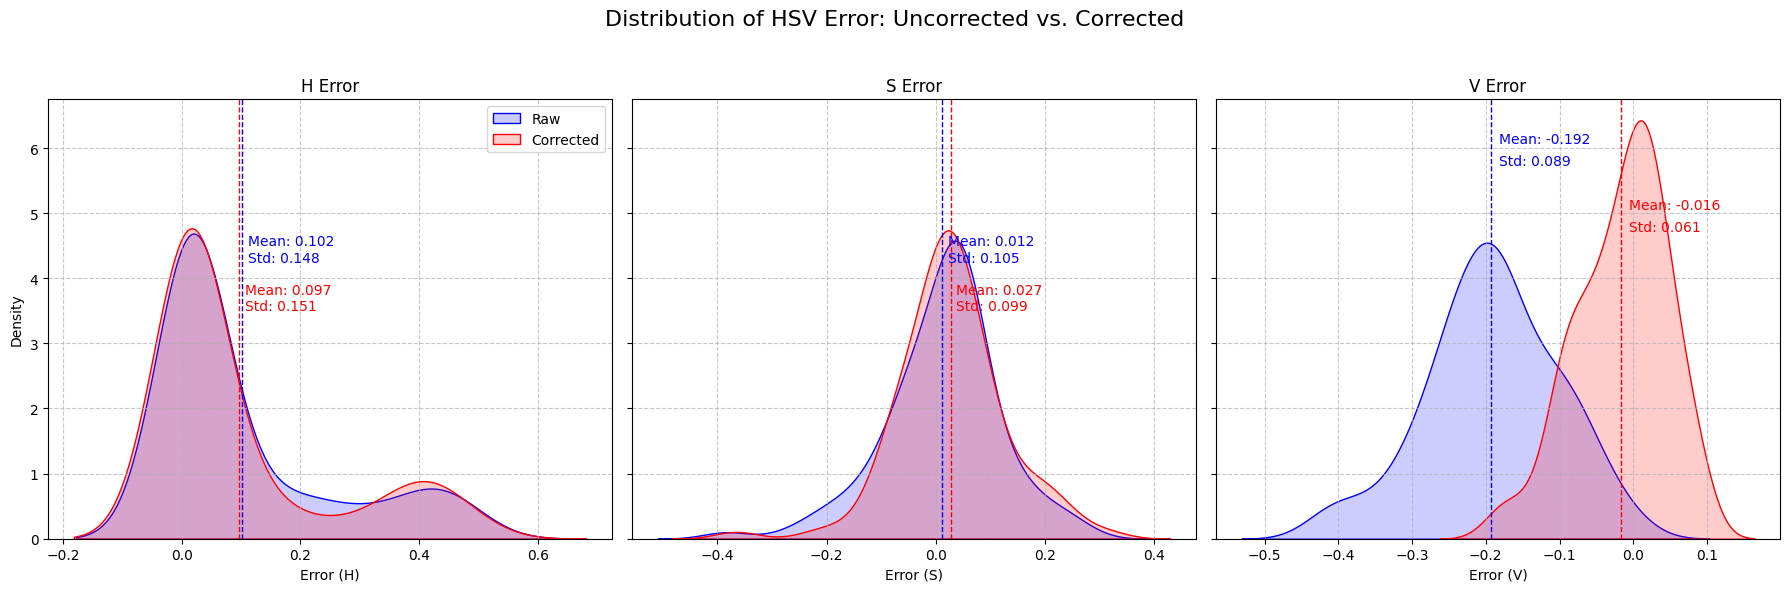

In [5]:
plotHSV(df_test_model_rgb);

Euclidean distance in the RGB space does not align with perception.
But model in LAB space is similar:

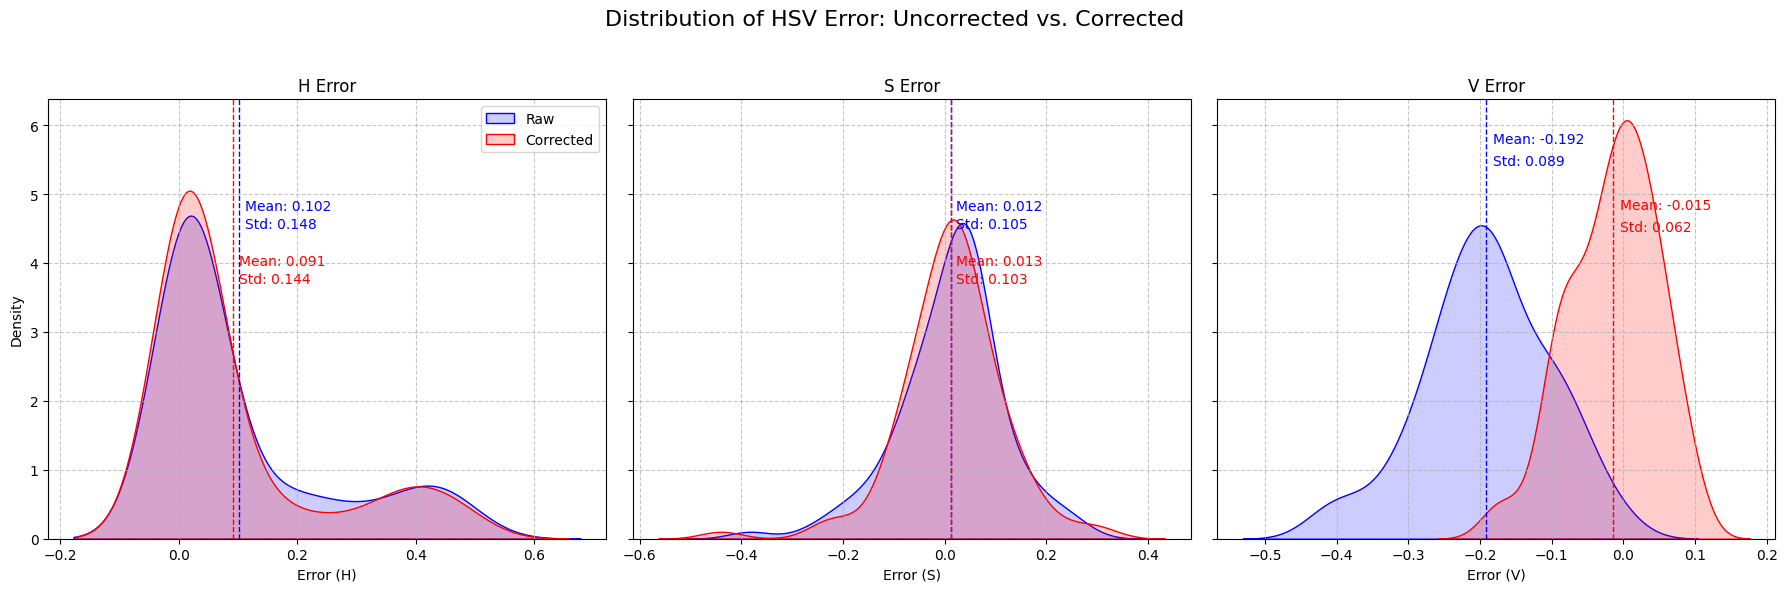

In [6]:
df_test_model_lab = convert_to_rgb(df_test_model_lab, "correction_r4_", from_space=ColorSpace.LAB)
plotHSV(df_test_model_lab);

Model parameters

In [7]:
# LAB space
pd.DataFrame(
    corrector_model_lab.coeffs.T,
    columns=['(offset)', 'b_meas', 'a_meas', 'L_meas', 'pitch', 'roll'],
    index=['L_corr', 'a_corr', 'b_corr']
).reindex(columns=['(offset)', 'L_meas', 'a_meas', 'b_meas', 'pitch', 'roll'])

,(offset),L_meas,a_meas,b_meas,pitch,roll
L_corr,3.293318,1.257174,-0.100625,0.097576,-0.130467,-0.033895
a_corr,2.553907,0.015729,1.316221,-0.200066,0.028825,-0.021061
b_corr,-0.830735,-0.068131,-0.090091,1.406801,0.097591,0.022229


In [8]:
# RGB space
pd.DataFrame(
    corrector_model_rgb.coeffs.T,
    columns=['(offset)', 'B_meas', 'G_meas', 'R_meas', 'pitch', 'roll'],
    index=['R_corr', 'G_corr', 'B_corr']
).reindex(columns=['(offset)', 'R_meas', 'G_meas', 'B_meas', 'pitch', 'roll'])

,(offset),R_meas,G_meas,B_meas,pitch,roll
R_corr,2.607578,1.285718,0.110181,-0.055168,-0.337130,-0.124545
G_corr,0.857116,-0.054204,1.623934,-0.243112,-0.379604,-0.074769
B_corr,4.211605,-0.029834,0.040269,1.364079,-0.563794,-0.130354


HSV plots are just one aspect.
Alternative perspective: overall Euclidean distance to ground truth on the test set

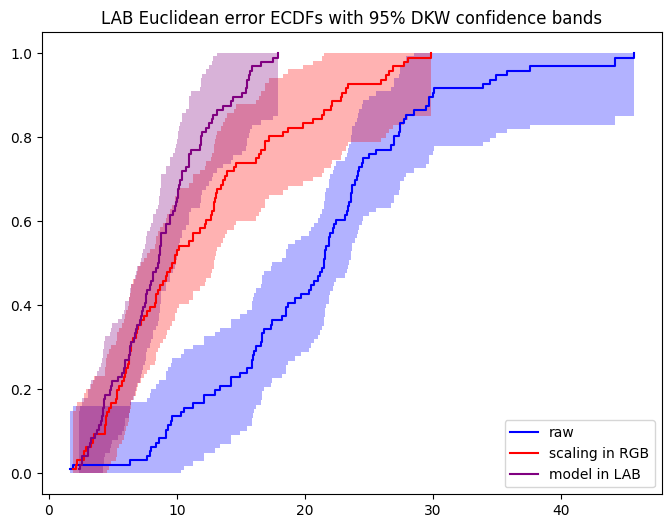

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("LAB Euclidean error ECDFs with 95% DKW confidence bands")
df_test_scaling = convert_rgb_cols(df_test_scaling, "correction_r4_", to=ColorSpace.LAB)
eucl_raw_lab = np.sqrt(
    (df_test_scaling["color_r4_l"] - df_test_scaling["gt__l"])**2 + \
    (df_test_scaling["color_r4_a"] - df_test_scaling["gt__a"])**2 + \
    (df_test_scaling["color_r4_b"] - df_test_scaling["gt__b"])**2
)
ax = plot_ecdf(ax, eucl_raw_lab, label="raw", color='blue')
eucl_scaling_lab = np.sqrt(
    (df_test_scaling["correction_r4_l"] - df_test_scaling["gt__l"])**2 + \
    (df_test_scaling["correction_r4_a"] - df_test_scaling["gt__a"])**2 + \
    (df_test_scaling["correction_r4_b"] - df_test_scaling["gt__b"])**2
)
ax = plot_ecdf(ax, eucl_scaling_lab, label="scaling in RGB", color='red')

eucl_model_lab = np.sqrt(
    (df_test_model_lab["correction_r4_l"] - df_test_model_lab["gt__l"])**2 + \
    (df_test_model_lab["correction_r4_a"] - df_test_model_lab["gt__a"])**2 + \
    (df_test_model_lab["correction_r4_b"] - df_test_model_lab["gt__b"])**2
)
ax = plot_ecdf(ax, eucl_model_lab, label="model in LAB", color='purple')

# df_test_model_rgb = convert_rgb_cols(df_test_model_rgb, "correction_r4_", to=ColorSpace.LAB)
# eucl_model_rgb = np.sqrt(
#     (df_test_model_rgb["correction_r4_l"] - df_test_model_rgb["gt__l"])**2 + \
#     (df_test_model_rgb["correction_r4_a"] - df_test_model_rgb["gt__a"])**2 + \
#     (df_test_model_rgb["correction_r4_b"] - df_test_model_rgb["gt__b"])**2
# )
# ax = plot_ecdf(ax, eucl_model_rgb, label="model in RGB", color='magenta')

ax.legend()
plt.show()

- Cross validation:
    - Model performance retains even if we drop up to 16 (out of 24) colors from training set!
    - Grayscale colors are important -- probably because they give information about the ambient light.
    - Green-ish colors are also important -- probably due to the camera?
- Other lighting conditions are significantly different.